In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import MeanShift
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score as cv_score
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn import svm
from scipy import stats
from sklearn.covariance import EllipticEnvelope
import snips as snp
from sklearn.ensemble import IsolationForest

# 1. Общая информация  
**Heart Disease UCI**  
https://www.kaggle.com/ronitf/heart-disease-uci  
Выполнил: Рыжов Дмитрий

In [8]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB
None


Пропусков нет

In [70]:
for column in df.columns:
    if len(np.unique(df[column].dropna().values))<10:
        print('{}: {}'.format(column,np.unique(df[column].dropna().values)))

sex: [0 1]
cp: [0 1 2 3]
fbs: [0 1]
restecg: [0 1 2]
exang: [0 1]
slope: [0 1 2]
ca: [0 1 2 3 4]
thal: [0 1 2 3]
target: [0 1]


**age** - возраст в годах  
**sex** - пол (1 = м; 0 = ж)  
**cp** - тип боли в груди  
**trestbps** - давление  
**chol** - холестерин  
**fbs** - уровень сахара в крови > 120 mg/dl (1 = true; 0 = false)  
**restecg** - результаты электрокардиографии  
**thalach** - максимальная частота сердечных сокращений  
**exang** - стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)  
**oldpeak** - ST depression  
**slope** - the slope of the peak exercise ST segment   
**ca** - число рсширенных сосудов (0-3)   
**thal** - тип деффекта   
**target** - наличие заболевания (1=да, 0=нет) 

In [71]:
df.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Проверим, какие типы признаков есть в датасете:

In [72]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

dtype_df.loc[:13,:]

,Count,Column Type
0,age,int64
1,sex,int64
2,cp,int64
3,trestbps,int64
4,chol,int64
5,fbs,int64
6,restecg,int64
7,thalach,int64
8,exang,int64
9,oldpeak,float64


Большинство признаков - целочисленные

# 2. Исследование
## 2.1 Кластеризация

In [73]:
def clustering(feat_a, feat_b, n):
    
    X = df.iloc[:100000, :].loc[:, [feat_a, feat_b]]
    print('Shape: ' + str(X.shape))
    kmeans = KMeans(n_clusters=n,init='k-means++')
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[feat_a], X[feat_b], c=y_kmeans, s=50)

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5);
    plt.xlabel(feat_a)
    plt.ylabel(feat_b)

Shape: (303, 2)


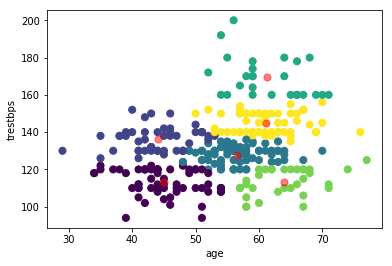

In [74]:
clustering('age', 'trestbps', 6)

Получаем два кластера(нормальное и повышенное давление) для людей среднего возраста и более широкую градацию для людей преклонного возраста(например: поиниженное, нормальное, слегка повышенное и повышенное)

Shape: (303, 2)


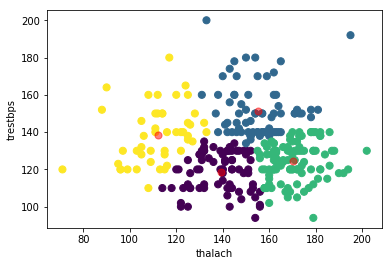

In [75]:
clustering('thalach', 'trestbps', 4)

Зеленый кластер: минимальный риск, желтый - высокая частота сердечных сокращений, синий - повышенная частота сердечных сокращений при высоком давлении(высокий риск заболевания), фиолетовый -низкая частота и немного повышенное давление(средний риск)

## 2.2 Отбор признаков

Data shape: (303, 13)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

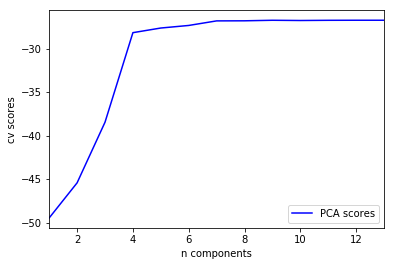

In [76]:
def plot_scores(d_scores):
    n_components = np.arange(1,d_scores.size+1)
    plt.plot(n_components, d_scores, 'b', label='PCA scores')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('cv scores')
    plt.legend(loc='lower right')
    plt.show()
            
data = np.array(df.values[:, :13])
print('Data shape: %s' % str(data.shape))

d_scores = np.empty(data.shape[1])
d_values = np.arange(1, data.shape[1]+1)
for index, d_num in enumerate(d_values):
    model_PCA = PCA(n_components=d_num, svd_solver='full')
    model_PCA.fit(data)
    d_scores[index] = np.mean(cv_score(model_PCA, data))

plot_scores(d_scores)

Видно, что по достижению 4 компонент рост незначителен

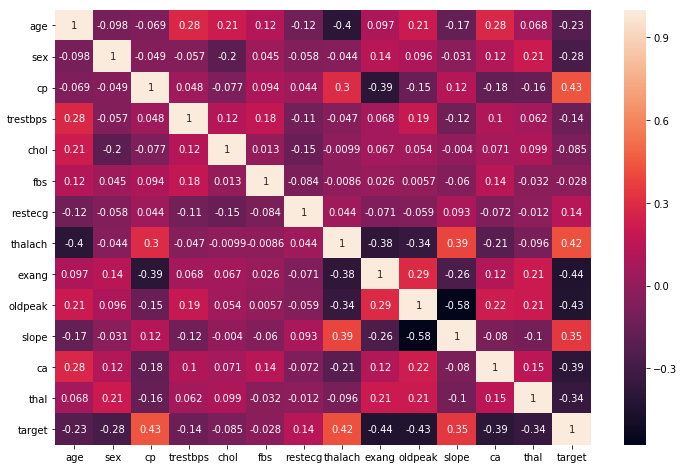

In [17]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)

Сильной корреляции между признаками нет.  
Наиболее информативные признаки: *exang*, *oldpeak*, *cp*, *thalach*

Так как общее число признаков невелико, можно произвести полный перебор признаков (Exhaustive Feature Selector)

In [18]:
X =  np.array(df.values[:, :13])
y = np.array(df.values[:, 13])

knn = KNeighborsClassifier(n_neighbors=3)

efs1 = EFS(knn, 
           min_features=1,
           max_features=4,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(X, y)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset :', efs1.best_feature_names_)

Features: 1092/1092

Best accuracy score: 0.83
Best subset : ('2', '10', '11', '12')


Лучшая комбинация признаков: *cp*, *slope*, *ca*, *thal*

## 2.3 Выделение аномалий

Для поиска аномалий воспользуемся алгоритмом изолирующего леса (IsolationForest)

In [186]:
def an_hist(feat_a, feat_b):
    X = df.iloc[:100000, :].loc[:, [feat_a, feat_b]]
    data = X.values[:,0:2]
    from sklearn.ensemble import IsolationForest
    rs=np.random.RandomState(0)
    clf = IsolationForest(max_samples=100,random_state=rs, contamination=.1) 
    clf.fit(data)
    if_scores = clf.decision_function(data)
    if_anomalies=clf.predict(data)
    if_anomalies=data[if_anomalies==-1]
    plt.hist(if_scores);
    plt.title('Histogram of Avg Anomaly Scores');

In [187]:
def an_plot(feat_a, feat_b):
    X = df.iloc[:100000, :].loc[:, [feat_a, feat_b]]
    data = X.values[:,0:2]
    from sklearn.ensemble import IsolationForest
    rs=np.random.RandomState(0)
    clf = IsolationForest(max_samples=100,random_state=rs, contamination=.1) 
    clf.fit(data)
    if_scores = clf.decision_function(data)
    if_anomalies=clf.predict(data)
    if_anomalies=data[if_anomalies==-1]
    plt.scatter(data[:,0],data[:,1],c='blue',s=20,edgecolor='k')
    plt.scatter(if_anomalies[:,0],if_anomalies[:,1],c='red',edgecolor='k')
    plt.xlabel(feat_a)
    plt.ylabel(feat_b)
    plt.title('Isolation Forests - Anomalies')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


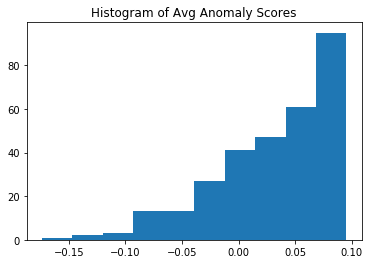

In [188]:
an_hist('thalach', 'trestbps')

Более низкие значения указывают на наблюдения, которые являются более аномальными.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


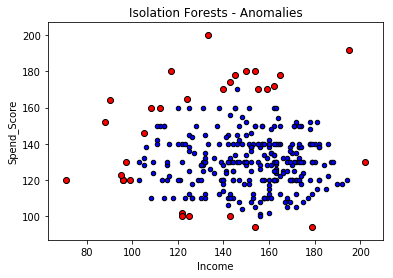

In [52]:
an_plot('thalach', 'trestbps')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


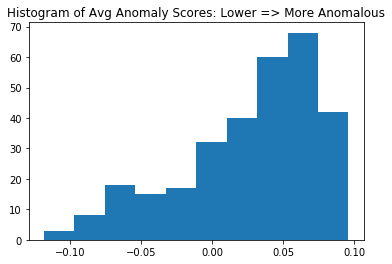

In [69]:
an_hist('age', 'trestbps')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


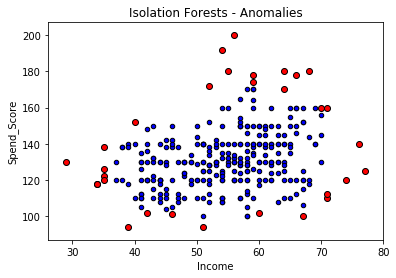

In [58]:
an_plot('age', 'trestbps')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


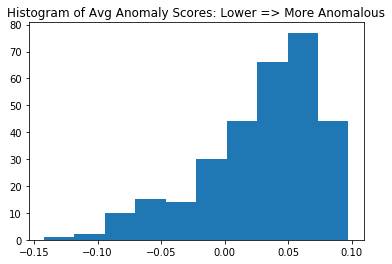

In [68]:
an_hist('age', 'chol')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


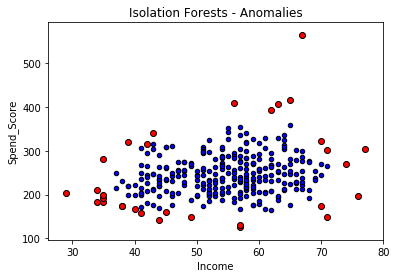

In [67]:
an_plot('age', 'chol')

Видим, что, как правило, к аномальным относится около 10% точек, что довольно много. Можно попробовать уменьшить этот процент, используя другие методы выделения аномалий, такие как метод опорных векторов для одного класса (OneClassSVM) или эллипсоидальную аппроксимацию данных (EllipticEnvelope)

# 3. Визуализация

Построим гистограммы признаков.

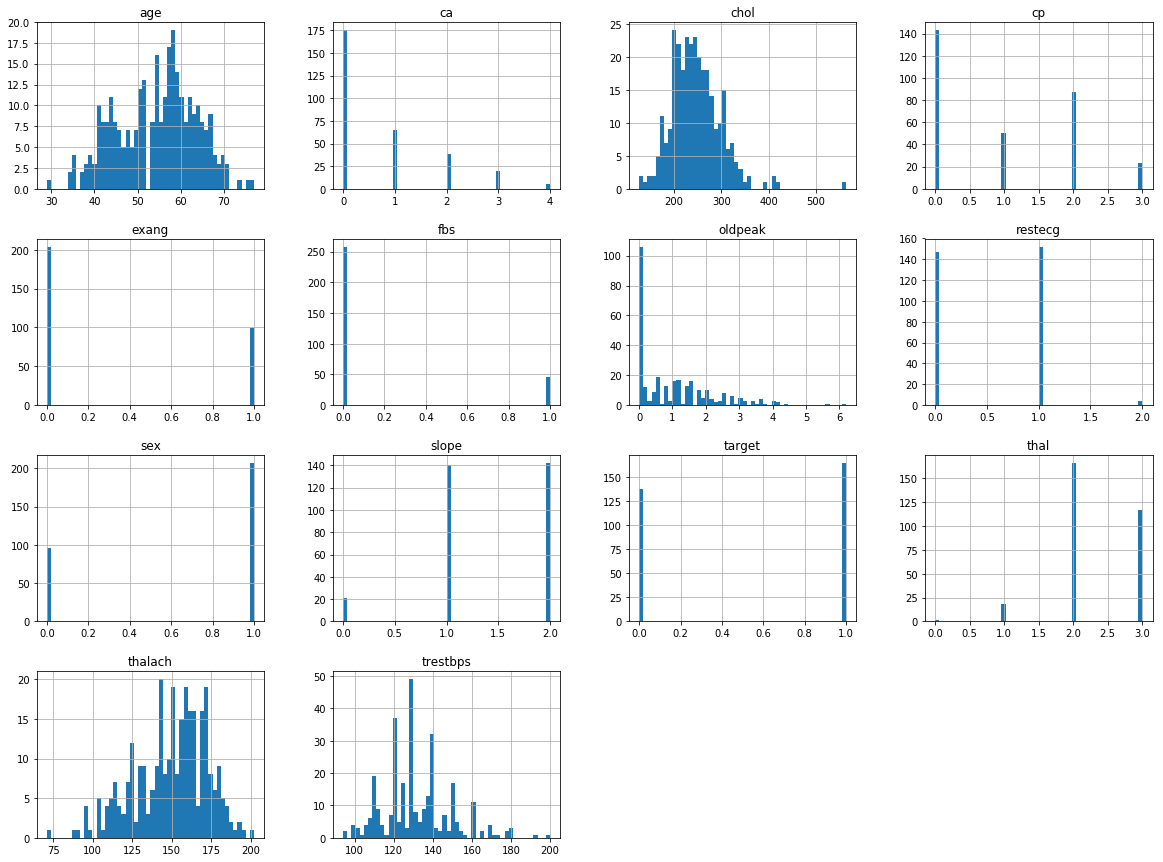

In [138]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

Из построенных гистограмм видно, что большинство признаков - категориальные.

Визуализируем категориальные признаки отдельно.

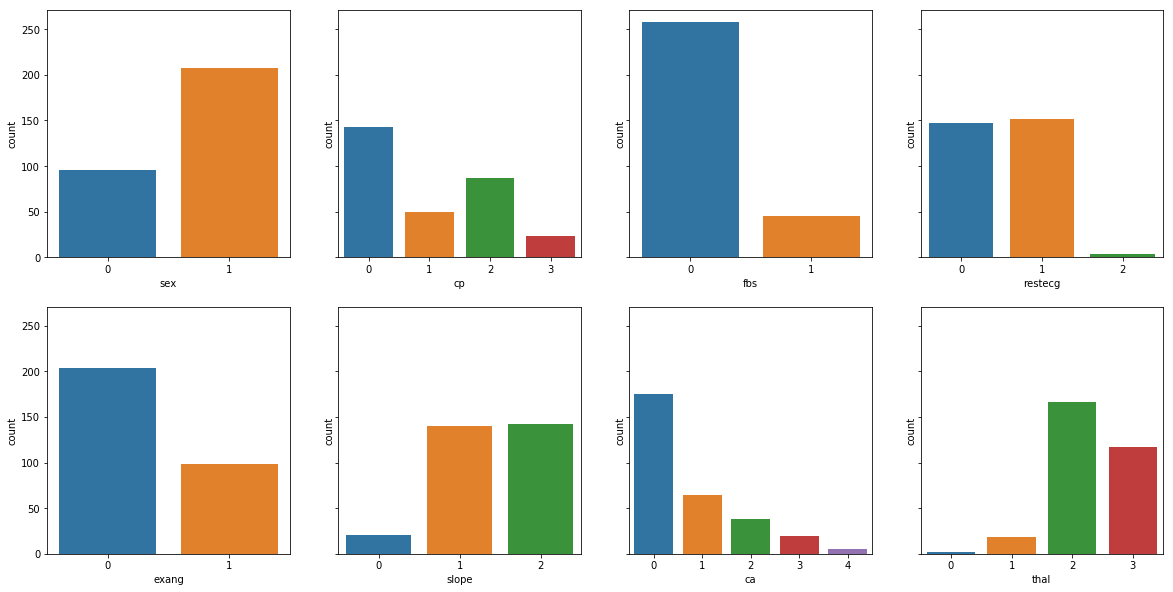

In [114]:
cat_features = [ 'sex', 'cp', 'fbs', 'restecg',
       'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
for i in range(len(cat_features)):
    sns.countplot(x=cat_features[i], data=df, ax=axes[i // 4, i % 4])

Посмотрим на распределение целевого признака, чтобы узнать, сбалансированы ли классы:

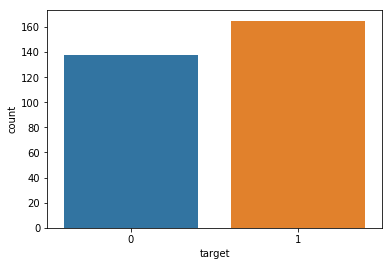

In [117]:
sns.countplot(df.target)

Видим, что классы сбалансированы.

Рассмотрим влияние пола на наличие болезней сердца.

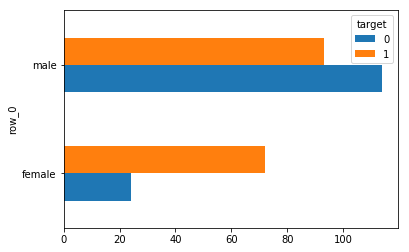

In [146]:
sex_infl = np.where(df.sex==1, 'male', 'female')
pd.crosstab(sex_infl, df.target).plot(kind='barh');


Видно, что женщины больше подвержены болезям сердца, чем мужщины.

Попробуем определить зависимость заболеваемости от возраста.

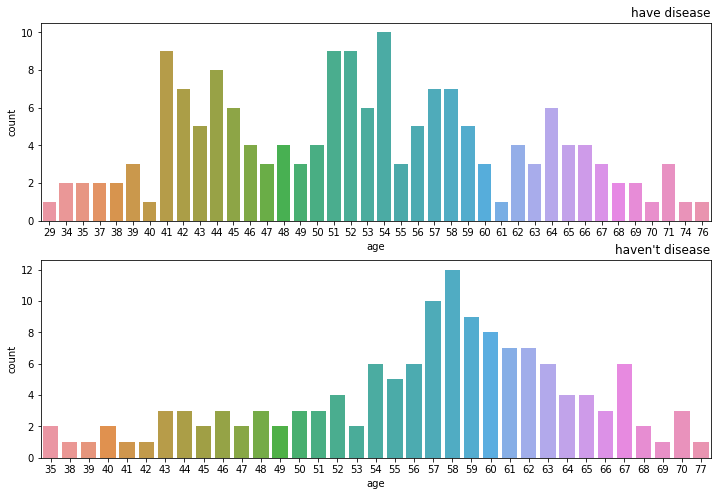

In [166]:
fig = plt.figure(figsize=(12,8))
pl1 = fig.add_subplot(2,1,1)
pl1.set_title('have disease', loc='right')
sns.countplot(df[df.target==1].age);
pl2 = fig.add_subplot(2,1,2)
pl2.set_title("haven't disease", loc='right')
sns.countplot(df[df.target==0].age);

Пик заболеваемости приходится на людей в возрасте 51-54, однако в 58 наблюдается максимальное число здоровых пациентов. Значит нельзя утверждать, что возраст прямо пропорцианален вероятноости заболевания.

Проанализируем, как влияет на наличие щаболевания больв груди

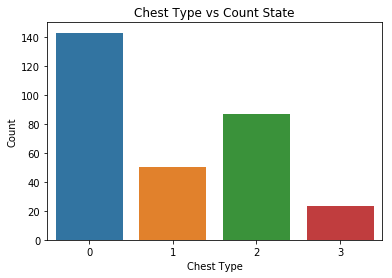

In [171]:
sns.countplot(df.cp)
plt.xlabel('Chest Type')
plt.ylabel('Count')
plt.title('Chest Type vs Count State')
plt.show()

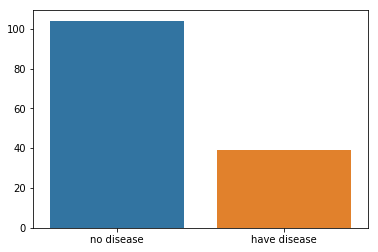

In [182]:
zero_target_f=len(df[(df.cp==0)&(df.target==0)])
zero_target_t=len(df[(df.cp==0)&(df.target==1)])
sns.barplot(x=['no disease','have disease'],y=[zero_target_f,zero_target_t])
plt.show()

При отсутствии боли вероятность болезни около 1/4

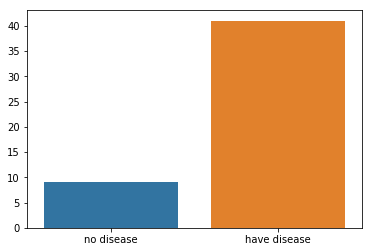

In [183]:
one_target_t=len(df[(df.cp==1)&(df.target==0)])
one_target_f=len(df[(df.cp==1)&(df.target==1)])
sns.barplot(x=['no disease','have disease'], y=[one_target_t,one_target_f])
plt.show()

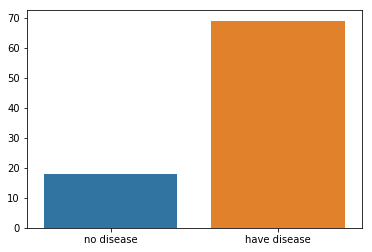

In [184]:
one_target_t=len(df[(df.cp==2)&(df.target==0)])
one_target_f=len(df[(df.cp==2)&(df.target==1)])
sns.barplot(x=['no disease','have disease'], y=[one_target_t,one_target_f])
plt.show()

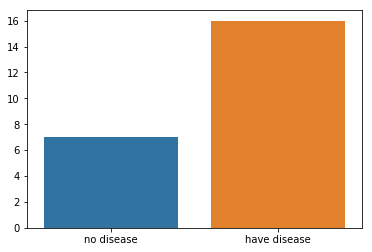

In [185]:
one_target_t=len(df[(df.cp==3)&(df.target==0)])
one_target_f=len(df[(df.cp==3)&(df.target==1)])
sns.barplot(x=['no disease','have disease'], y=[one_target_t,one_target_f])
plt.show()

При отсутствии боли вероятность болезни мало, а при её наличии в том или ином виде - велика, что логично.

# Вывод

Были проанализированны данные о заболеваниях сердца: проведена кластеризация, определены наиболее информативные признаки, найдена лучшая комбинация признаков, выделены аномалии, проведена визуализация и оценено влияние отдельных признаков на целевой.